In [1]:
from qctoolkit.pulses import TablePulseTemplate
import qctoolkit.pulses.plotting
import numpy as np
import sympy as sp
from sympy import sympify as spy

#measurement point
M = sp.IndexedBase('M', shape=(2, ))

#singlet initialization point
S_init = sp.IndexedBase('S_init', shape=(2, ))

#operation point
O = sp.IndexedBase('O', shape=(2, ))

#singlet triplet transition
ST = sp.IndexedBase('ST', shape=(2, ))
ST_jump = sp.IndexedBase('ST_jump', shape=(2, ))

#init duration
init_dur = ('t_init')


def from_entry_list(tuple_list, channel_names=None, **kwargs):
    max_len = max(len(t) for t in tuple_list)
    min_len = min(len(t) for t in tuple_list)
        
    if max_len-min_len > 1:
        raise Exception()
    elif max_len-min_len == 1:
        num_chan = min_len-1
    else:
        if all(t[-1] in TablePulseTemplate.interpolation_strategies.keys() or t[-1] in TablePulseTemplate.interpolation_strategies.values()
              for t in tuple_list):
            num_chan = min_len - 2
        elif any(t[-1] in TablePulseTemplate.interpolation_strategies.keys() or t[-1] in TablePulseTemplate.interpolation_strategies.values()
                 for t in tuple_list):
            raise Exception()
        else:
            num_chan = min_len - 1
    
    if channel_names is None:
        channel_names = list(range(num_chan))
    elif len(channel_names) != num_chan:
        raise Exception()
        
    parsed = {channel_name: [] for channel_name in channel_names}
        
    
    for time, *data in tuple_list:
        if len(data) == num_chan:
            volts = data
            interp = 'hold'
        else:
            *volts, interp = data
        
        for channel_name, volt in zip(channel_names, volts):
              parsed[channel_name].append((time, volt, interp))
    
    return TablePulseTemplate(parsed, **kwargs)
        


time_diffs = [          't_init', 't_ramp_up', '0',      't_ramp_low']
voltages =   ['S_init', 'M',      'ST_up',     'ST_low', 'O']
interpol =   ['hold',   'jump',   'linear',    'jump',   'linear']

times = [0] + ['+'.join(time_diffs[:i+1]) for i in range(len(time_diffs))]
v_X = [v + '_X' for v in voltages]
v_Y = [v + '_Y' for v in voltages]

substitutions = {'t_ramp_up': 'ST_up-M'}

times = [sp.sympify(t) for t in times]

init = TablePulseTemplate({'RFX': [(t, v, interp) for t, v, interp in zip(times, v_X, interpol)],
                           'RFY': [(t, v, interp) for t, v, interp in zip(times, v_Y, interpol)]},
                         identifier='init')


#qctoolkit.pulses.plotting.plot(init, dict(t_init=2, t_ramp_up=3, t_ramp_low=2, S_init))

C:\Users\lablocal\Anaconda3\envs\lab_master\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


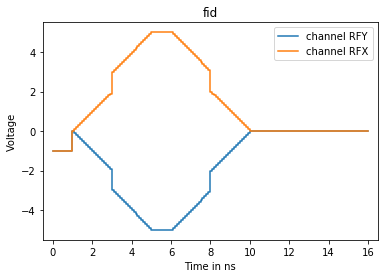

In [2]:
fid_direct = TablePulseTemplate({'RFX': [(0,                'S_init_X'),
                                         ('t_init',         'M_X',      'hold'),
                                         ('t_ST_fall',      'ST_up_X',  'linear'),
                                         ('t_ST_fall',      'ST_low_X'),
                                         ('t_op',           'O_X',      'linear'),
                                         ('t_op + t_fid',   'O_X',      'hold'),
                                         ('t_ST_jump',      'ST_low_X', 'linear'),
                                         ('t_ST_jump',      'ST_up_X'),
                                         ('t_meas_start',   'M_X',      'linear'),
                                         ('t_meas_end',     'M_X',      'hold'),
                                         ('total_duration', 'M_X',      'hold')],
                                 'RFY': [(0,                'S_init_Y'),
                                         ('t_init',         'M_Y',      'hold'),
                                         ('t_ST_fall',      'ST_up_Y',  'linear'),
                                         ('t_ST_fall',      'ST_low_Y'),
                                         ('t_op',           'O_Y',      'linear'),
                                         ('t_op + t_fid',   'O_Y',      'hold'),
                                         ('t_ST_jump',      'ST_low_Y', 'linear'),
                                         ('t_ST_jump',      'ST_up_Y'),
                                         ('t_meas_start',   'M_Y',      'linear'),
                                         ('t_meas_end',     'M_Y',      'hold'),
                                         ('total_duration', 'M_Y',      'hold')]},
                                identifier='fid',
                                measurements=[('MEAS', 't_meas_start', 't_meas_end - t_meas_start')])

example_values = dict(t_init=1, t_ST_fall=3, t_op=5, t_fid=1, t_ST_jump=8, t_meas_start=10, t_meas_end=14, total_duration=16,
                      S_init_X=-1, M_X=0, ST_up_X=2, ST_low_X=3, O_X=5,
                      S_init_Y=-1, M_Y=0, ST_up_Y=-2, ST_low_Y=-3, O_Y=-5)

from qctoolkit.pulses.plotting import plot

plot(fid_direct, example_values, 10)

In [15]:
S_init_X, S_init_Y = sp.symbols('S_init_X S_init_Y')
M_X, M_Y = sp.symbols('M_X M_Y')

ST_plus_X, ST_plus_Y = sp.symbols('ST_plus_X ST_plus_Y')
ST_plus_width_X, ST_plus_width_Y = sp.symbols('ST_plus_width_X, ST_plus_width_Y')

ST_plus_begin_X = ST_plus_X - ST_plus_width_X/2
ST_plus_begin_Y = ST_plus_Y + ST_plus_width_Y/2
ST_plus_end_X = ST_plus_X - ST_plus_width_X/2
ST_plus_end_Y = ST_plus_Y + ST_plus_width_Y/2

O_X, O_Y = sp.symbols('O_X, O_Y')

ramp_speed_X = sp.symbols('ramp_speed_X')

t_init = sp.symbols('t_init')

t_ST_jump = t_init + (ST_plus_begin_X - M_X)/ramp_speed_X
t_op = t_ST_jump + (O_X - ST_plus_end_X)/ramp_speed_X

conditions = [ST_plus_begin_X >= M_X,
              ST_plus_end_X <= O_X,
              ST_plus_begin_Y >= M_Y,
              ST_plus_end_Y <= O_Y]

init = from_entry_list([(0,        'S_init_X', 'S_init_Y'),
                        ('t_init', 'M_X',      'M_Y',       'hold'),
                        (t_ST_jump, ST_plus_begin_X, ST_plus_begin_Y, 'linear'),
                        (t_ST_jump, ST_plus_end_X,   ST_plus_end_Y),
                        (t_op,      O_X, O_Y, 'linear')],
                       identifier='init_up_down',
                       parameter_constraints=conditions)



In [4]:
t_ST_jump = (O_X - ST_plus_end_X)/ramp_speed_X
t_meas_start = t_ST_jump + (ST_plus_begin_X - M_X)/ramp_speed_X
t_meas_end = t_meas_start + sp.symbols('t_meas')

meas = from_entry_list([(0, 'O_X', 'O_Y'),
                        (t_ST_jump, ST_plus_end_X,   ST_plus_end_Y, 'linear'),
                        (t_ST_jump, ST_plus_begin_X, ST_plus_begin_Y),
                        (t_meas_start, 'M_X', 'M_Y', 'linear'),
                        (t_meas_end, 'M_X', 'M_Y', 'hold')],
                       measurements=[('M', t_meas_start, 't_meas')],
                       identifier='meas')

In [12]:
from qctoolkit.pulses import SequencePulseTemplate

fid_wait = from_entry_list([('t_fid', 'O_X', 'O_Y')])

one_run = SequencePulseTemplate(init, fid_wait, meas)

fill = from_entry_list([(sp.symbols('total_duration')-one_run.duration.sympified_expression, 'M_X', 'M_Y')])

filled_run = SequencePulseTemplate(one_run, fill)

filled_run.duration.sympified_expression.simplify()

total_duration

In [6]:
from qctoolkit.pulses.loop_pulse_template import ForLoopPulseTemplate
from qctoolkit.pulses import MappingTemplate

mapped_run = MappingTemplate(filled_run, parameter_mapping={'t_fid': 'n*fid_step'}, allow_partial_parameter_mapping=True)

fid_ramp = ForLoopPulseTemplate(mapped_run, loop_index='n', loop_range=(sp.symbols('N'),))
fid_ramp.parameter_names

{'M_X',
 'M_Y',
 'N',
 'O_X',
 'O_Y',
 'ST_plus_X',
 'ST_plus_Y',
 'ST_plus_width_X',
 'ST_plus_width_Y',
 'S_init_X',
 'S_init_Y',
 'fid_step',
 'ramp_speed_X',
 't_init',
 't_meas',
 'total_duration'}

C:\Users\lablocal\Anaconda3\envs\lab_master\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


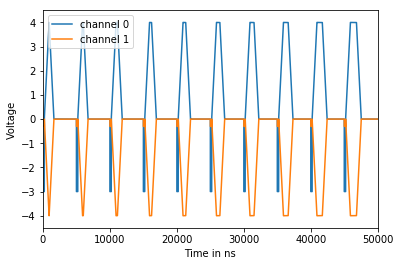

In [10]:
example_parameters = dict(M_X=0, M_Y=0,
                          O_X=4, O_Y=-4,
                          S_init_X=-3, S_init_Y=-0.3,
                          ramp_speed_X=1/180,
                          ST_plus_X=0.4, ST_plus_Y=-0.4,
                          ST_plus_width_X=0.2, ST_plus_width_Y=0.2,
                          t_meas=1000,
                          t_init=200,
                          total_duration=5000,
                          N=10, fid_step=100
                         )
                          
plot(fid_ramp, example_parameters)

In [18]:
'@start','@fill','@wait','@reload','@adprep','@wait','@adread','@latch_readout'




t_ST_jump = (ST_plus_begin_X - M_X)/ramp_speed_X
t_op = t_ST_jump + (O_X - ST_plus_end_X)/ramp_speed_X
adprep = from_entry_list([(0,         M_X,             M_Y),
                          (t_ST_jump, ST_plus_begin_X, ST_plus_begin_Y, 'linear'),
                          (t_ST_jump, ST_plus_end_X,   ST_plus_end_Y),
                          (t_op,      O_X,             O_Y, 'linear')],
                         
                         parameter_constraints=[M_X < ST_plus_begin_X, ST_plus_end_X < O_X],
                         identifier='adprep')

t_ST_jump = (O_X - ST_plus_end_X)/ramp_speed_X
t_meas_start = t_ST_jump + (ST_plus_begin_X - M_X)/ramp_speed_X
adread = from_entry_list([(0, O_X, O_Y),
                          (t_ST_jump, ST_plus_end_X, ST_plus_end_Y, 'linear'),
                          (t_ST_jump, ST_plus_begin_X,   ST_plus_begin_Y),
                          (t_meas_start, M_X, M_Y, 'linear')],
                         parameter_constraints=[M_X < ST_plus_begin_X, ST_plus_end_X < O_X],
                         identifier='adread')



In [83]:
from qctoolkit.expressions import Expression

class PointPulseTemplate(TablePulseTemplate):
    def __init__(self, time_point_tuple_list, channel_names, **kwargs):
        
        self._time_point_tuple_list = []
        self._ordered_channels = channel_names
        entries = {channel_name: [] for channel_name in channel_names}
        
        for time_point_tuple in time_point_tuple_list:
            if len(time_point_tuple) == 2:
                time, point, interpolation = time_point_tuple, 'hold'
            else:
                time, point, interpolation = time_point_tuple
            
            if isinstance(point, str):
                point = sp.IndexedBase(point, shape=(len(channel_names), ))
            for ch_i, channel_name in enumerate(channel_names):
                entries[channel_name].append((time, Expression(point[ch_i]), interpolation))
            self._time_point_tuple_list.append((time, point, interpolation))
        
        super().__init__(entries=entries, **kwargs)
    
    @property
    def time_point_tuple_list(self):
        return self._time_point_tuple_list
    
    def get_serialization_data(self, serializer):
        super_data = super().get_serialization_data(serializer)
        super_data.pop('entries')
        super_data['time_point_tuple_list'] = [(time, str(point), str(interp))
                                                for time, point, interp in self.time_point_tuple_list]
        super_data['channel_names'] = self._ordered_channels
        return super_data
    
    @staticmethod
    def deserialize(serializer, time_point_tuple_list, channel_names, **kwargs):
        PointPulseTemplate(time_point_tuple_list=time_point_tuple_list,
                           channel_names=channel_names, **kwargs)
        
        

ppt = PointPulseTemplate([(0, 'S_init', 'hold'),
                          ('t_init', 'M', 'jump'),
                          ('t_2', 'O', 'linear')],
                         ['RFX', 'RFY'])

class MemoryBackend(qctoolkit.serialization.StorageBackend):
    def __init__(self):
        self.storage = dict()
    
    def put(self, identifier, data, overwrite):
        self.storage[identifier] = data

    def get(self, identifier):
        return self.storage[identifier]
    
    def exists(self, identifier):
        return identifier in self.storage

import qctoolkit.serialization
be = MemoryBackend()
s = qctoolkit.serialization.Serializer(be)

In [84]:
d = ppt.get_serialization_data(None)

s.serialize(ppt)

In [85]:
ppt2 = s.deserialize('main')

In [17]:
def debug(f, *args, **kwargs):
    import traceback, sys, code
    try:
        f(*args, **kwargs)
    except:
        type, value, tb = sys.exc_info()
        traceback.print_exc()
        last_frame = lambda tb=tb: last_frame(tb.tb_next) if tb.tb_next else tb
        frame = last_frame().tb_frame
        ns = dict(frame.f_globals)
        ns.update(frame.f_locals)
        code.interact(local=ns)